In [1]:
import pandas as pd #module to work with dataframes
import networkx as nx #module to work with networks
import numpy as np
import matplotlib.pyplot as plt
from Functions import *

# Dynamics on networks and dynamics of networks

# Dynamics of networks: Temporal networks

To get some practice with temporal networks we will analyze the co-occurrence network of the characters in the Game of Thrones books. Here, two characters are considered to co-occur if their names appear in the vicinity of 15 words from one another in the books. The edge weight corresponds to the number of interactions. . The dataset is publicly avaiable for the 5 books at https://github.com/mathbeveridge/asoiaf. Let's take a look at it

In [2]:
books = load_game_of_thrones_data()

In [3]:
books

,Source,Target,Type,weight,book,weight_inv
id,,,,,,
0,Addam-Marbrand,Jaime-Lannister,Undirected,3,1.0,0.333333
1,Addam-Marbrand,Tywin-Lannister,Undirected,6,1.0,0.166667
2,Aegon-I-Targaryen,Daenerys-Targaryen,Undirected,5,1.0,0.200000
3,Aegon-I-Targaryen,Eddard-Stark,Undirected,4,1.0,0.250000
4,Aemon-Targaryen-(Maester-Aemon),Alliser-Thorne,Undirected,4,1.0,0.250000
...,...,...,...,...,...,...
3904,Tyrion-Lannister,Ysilla,undirected,11,5.0,0.090909
3905,Tywin-Lannister,Wylis-Manderly,undirected,3,5.0,0.333333
3906,Victarion-Greyjoy,Wulfe,undirected,3,5.0,0.333333


As you can see this data easily translates to a network problem. Now it's time to create a network.
We create a graph for each book. It's possible to create one `MultiGraph`(Graph with multiple edges between nodes) instead of 5 graphs, but it is easier to analyse and manipulate individual `Graph` objects rather than a `MultiGraph`. We can consider this a sort of **temporal network**, where each book is a different snapshot at the relationshiops between characters. As we have  books we will have 5 snapshots. While there are librars that allow you to better work with temporal networks, you can still do that by combining your analysis of the 5 networks.

In [4]:
# we create a list of graph objects using
# nx.from_pandas_edgelist and specifying
# the edge attributes.

graphs = [nx.from_pandas_edgelist(
          books[books.book==i],
          source='Source', target='Target',
          edge_attr=['weight', 'weight_inv'])
          for i in range(1, 6)]

In [5]:
#what is contained in the list? # a list of 5 networks
graphs

In [6]:
# The Graph object associated with the first book.
graphs[0]

In [7]:
# To access the relationship edges in the graph use(data=True)
relationships = list(graphs[0].edges(data=True)) #creates a list of all the edges with their attributes (only weight, as "book" we took it out when we did 5 networks!!

In [8]:
relationships[0:3]

[('Addam-Marbrand',
  'Jaime-Lannister',
  {'weight': 3, 'weight_inv': 0.3333333333333333}),
 ('Addam-Marbrand',
  'Tywin-Lannister',
  {'weight': 6, 'weight_inv': 0.1666666666666666}),
 ('Jaime-Lannister', 'Aerys-II-Targaryen', {'weight': 5, 'weight_inv': 0.2})]

## Finding the most important node i.e character in these networks.

Let's use our network analysis knowledge to see what we can learn of these Graphs that we have just created, and their changes trough time.

Is it Jon Snow, Tyrion, Daenerys, or someone else the most central character? Let's see! Network Science offers us many different metrics to measure the importance of a node in a network as we saw in lesson 2A. Note that there is no "correct" way of calculating the most important node in a network, every metric has a different meaning.

First, let's measure the importance of a node in a network by looking at the number of neighbors it has, that is, the number of nodes it is connected to. 

<div class="alert alert-block alert-success"><b>Up to you:</b>
<h4> Exercise 24</h4>
    
Considering that you seek to compare the importance of same nodes across different networks (as the network will be changing in time) in term of their **number of neighbours**, what metric should you use, **degree cenrtality** or **node degree**?
    
    
</div>

In [9]:
# no need to code, just think and remember!
# %load ./snippets/ex24.py

Using this measure, let's extract the top ten important characters from the first book (`graphs[0]`) and the fifth book (`graphs[4]`).

In [10]:
# We use the in-built degree_centrality method
deg_cen_book1 = pd.Series(dict(nx.degree_centrality(graphs[0]))).sort_values(ascending=False)
deg_cen_book5 = pd.Series(dict(nx.degree_centrality(graphs[4]))).sort_values(ascending=False)

In [11]:
print(deg_cen_book1.head(10))
print(deg_cen_book5.head(10))

Eddard-Stark         0.354839
Robert-Baratheon     0.268817
Tyrion-Lannister     0.247312
Catelyn-Stark        0.231183
Jon-Snow             0.198925
Robb-Stark           0.188172
Sansa-Stark          0.188172
Bran-Stark           0.172043
Cersei-Lannister     0.161290
Joffrey-Baratheon    0.161290
dtype: float64
Jon-Snow              0.196203
Daenerys-Targaryen    0.183544
Stannis-Baratheon     0.148734
Tyrion-Lannister      0.104430
Theon-Greyjoy         0.104430
Cersei-Lannister      0.088608
Barristan-Selmy       0.079114
Hizdahr-zo-Loraq      0.069620
Asha-Greyjoy          0.056962
Melisandre            0.053797
dtype: float64


## Evolution of importance of characters over the books

According to degree centrality the most important character in the first book is Eddard Stark but he is not even in the top 10 of the fifth book. 
The importance changes over the course of five books, because you know stuff happens ;)

How can we study changes in characters cenrtality? For example looking at the evolution of degree centrality of some relevant charactesr like Eddard Stark, Jon Snow, or Tyrion which showed up in the top 10 of degree centrality in first book.

For that, we need to create a dataframe that contains: the character, the book, and the character importance in that book. We will create a dataframe with character columns and index as books, where every entry is the degree centrality of the character in that particular book and plot the evolution of the degree centrality of Eddard Stark, Jon Snow and Tyrion.

In [12]:
evolK = [nx.degree_centrality(graph) for graph in graphs] #creates a list containing the dictionaries of degree centralities of the charactesr
evolK_df = pd.DataFrame.from_records(evolK).fillna(0) #create a dataframe using book as index, characters as columns, and centrality as values

In [13]:
evolK_df.head()

,Addam-Marbrand,Jaime-Lannister,Tywin-Lannister,Aegon-I-Targaryen,Daenerys-Targaryen,Eddard-Stark,Aemon-Targaryen-(Maester-Aemon),Alliser-Thorne,Bowen-Marsh,Chett,...,Yellow-Dick,Walda-Frey-(daughter-of-Merrett),Roose-Ryswell,Scar,Shrouded-Lord,Theomore,William-Foxglove,Willow-Witch-eye,Thistle,Wulfe
0,0.010753,0.155914,0.118280,0.010753,0.112903,0.354839,0.037634,0.053763,0.026882,0.016129,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.081395,0.065891,0.019380,0.069767,0.085271,0.023256,0.015504,0.000000,0.003876,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.026490,0.149007,0.096026,0.009934,0.079470,0.052980,0.059603,0.023179,0.033113,0.016556,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.014652,0.234432,0.058608,0.000000,0.000000,0.029304,0.025641,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.031646,0.028481,0.003165,0.183544,0.044304,0.015823,0.003165,0.028481,0.000000,...,0.009494,0.006329,0.003165,0.006329,0.003165,0.006329,0.003165,0.003165,0.003165,0.003165


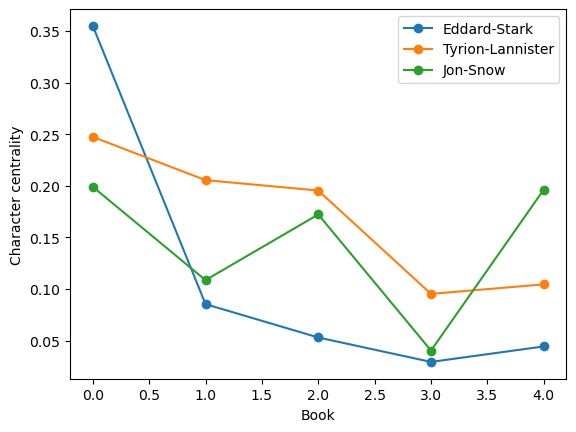

In [14]:
characters=['Eddard-Stark','Tyrion-Lannister','Jon-Snow']#'Daenerys-Targaryen','Arya-Stark'
evolK_df[characters].plot(style='o-')
plt.ylabel("Character centrality")
plt.xlabel("Book")
plt.show()

We can see that the importance of Eddard Stark in the network dies off and with Jon Snow there is a drop in the fourth book but a sudden rise in the fifth book

## Betweeness centrality

Let's do this for Betweeness centrality and check if this makes any difference. As different centrality method use different measures underneath, they find nodes which are important in the network. A centrality method like Betweeness centrality finds nodes which are structurally important to the network, which binds the network together and densely.

In [15]:
evolB = [nx.betweenness_centrality(graph, weight="weight_inv") for graph in graphs]
evolB_df = pd.DataFrame.from_records(evolB).fillna(0)

In [16]:
#let's find the characters that are more relevant por joining many plots:
characters=evolB_df.sum().sort_values(ascending=False).index.to_list()[0:5]

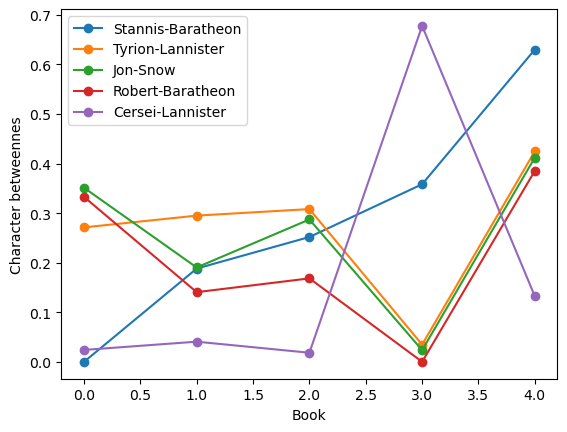

In [17]:
evolB_df[characters].plot(style='o-')
plt.ylabel("Character betweennes")
plt.xlabel("Book")
plt.show()

## Evolution of Roles over time
We can now determine characters that are incresing or decreasing in importance in the plot of the books!

In [18]:
all_characters=evolK_df.columns
evolK_df.reset_index(names="book",inplace=True)

In [19]:
Centrality_evol=evolK_df[all_characters].corrwith(evolK_df["book"])

In [20]:
loosers=Centrality_evol.sort_values(ascending=True).index.to_list()[0:3]
winners=Centrality_evol.sort_values(ascending=False).index.to_list()[0:3]

In [21]:
Centrality_evol.sort_values(ascending=False)

Doran-Martell       0.931626
Tristifer-Botley    0.862736
Sybell-Spicer       0.861275
Asha-Greyjoy        0.847298
Obara-Sand          0.841223
                      ...   
Varys              -0.955567
Ilyn-Payne         -0.956404
Bronn              -0.961166
Catelyn-Stark      -0.969633
Nan                -0.982292
Length: 796, dtype: float64

<Axes: >

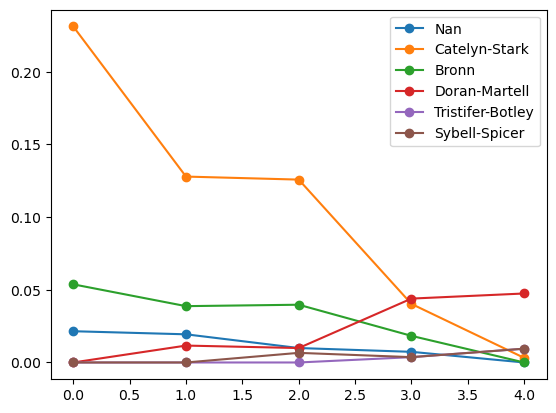

In [22]:
evolK_df[loosers + winners ].plot(style='o-')

## Node and Link constancy

In temporal networks we can also see if nodes and links persist over time. We can maka a bipartite "network" of books and nodes, and books and edges, and easily see their presence trough time

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h4> Exercise 25</h4>
    
Create a bipartite network of books and interactions. In that network the nodes in one set are the different books, while the nodes in the second set are the interactions between the characters.
These types of networks are used, for example, to study how ecological interactions are structured in different fields.
    
- 1.  How many interactions characters are shared between the first and the second book?
- 2.  What books share the most number of character interactions?
    
Create a bipartite network of books and characters. In that network the nodes in one set are the different books, while the nodes in the second set are the characters.
- 3. What books share the most number of characters?
</div>

In [23]:
## your code here


In [24]:
# %load ./snippets/ex25.py

In [35]:
# %load ./snippets/ex25b.py

,B1,B2,B3,B4,B5
B1,0.0,90.0,101.0,71.0,77.0
B2,90.0,0.0,136.0,88.0,101.0
B3,101.0,136.0,0.0,108.0,122.0
B4,71.0,88.0,108.0,0.0,85.0
B5,77.0,101.0,122.0,85.0,0.0


## Air traffic
we will analyse the evolution of US Airport Network between 1990 and 2015. This dataset contains data for 25 years[1995-2015] of flights between various US airports and metadata about these routes. Taken from Bureau of Transportation Statistics, United States Department of Transportati

In [ ]:
def load_airports_data():
    pass_air_data = pd.read_csv("./data/passengers.csv", index_col="id")
    return pass_air_data

In [ ]:
pass_air_data=load_airports_data()

In [ ]:
pass_air_data.head()

In [ ]:
passenger_graph = nx.from_pandas_edgelist(
    pass_air_data, source='ORIGIN',
    target='DEST', edge_key='YEAR',
    edge_attr=['PASSENGERS', 'UNIQUE_CARRIER_NAME'],
    create_using=nx.MultiDiGraph())

We have created a MultiDiGraph object `passenger_graph` which contains all the information from the dataframe `pass_air_data`. `ORIGIN` and `DEST` represent the column names in the dataframe `pass_air_data` used to construct the edge. As this is a `MultiDiGraph` we can also give a name/key to the multiple edges between two nodes and `edge_key` is used to represent that name and in this graph `YEAR` is used to distinguish between multiple edges between two nodes. `PASSENGERS` and `UNIQUE_CARRIER_NAME` are added as edge attributes which can be accessed using the nodes and the key form the MultiDiGraph object.

Let's check if can access the same information (the 2006 route between JFK and AUS) using our `passenger_graph`.

To check an edge between two nodes in a Graph we can use the syntax `GraphObject[source][target]` and further specify the edge attribute using `GraphObject[source][target][attribute]`.

<!-- Let's see if `passenger_graph['JFK']['AUS'][2006]` works. -->

In [ ]:
passenger_graph['JFK']['AUS'][2006]

In [ ]:
# Route betweeen New York-JFK and SFO

values = [(year, attr['PASSENGERS'])
          for year, attr in 
          passenger_graph['JFK']['SFO'].items()]
x, y = zip(*values)
plt.plot(x, y)
plt.show()

In [ ]:
pass_air_data.groupby(
    ['YEAR']).sum()['PASSENGERS'].plot()
plt.show()

In [ ]:
def year_network(G, year):
    """ Extract edges for a particular year from
        a MultiGraph. The edge is also populated with
        two attributes, weight and weight_inv where
        weight is the number of passengers and
        weight_inv the inverse of it.
    """
    year_network = nx.DiGraph()
    for edge in G.edges:
        source, target, edge_year = edge
        if edge_year == year:
            attr = G[source][target][edge_year]
            year_network.add_edge(
                source, target,
                weight=attr['PASSENGERS'],
                weight_inv=1/(attr['PASSENGERS']
                if attr['PASSENGERS'] != 0.0 else 1),
                airlines=attr['UNIQUE_CARRIER_NAME'])
    return year_network

In [ ]:
pass_2015_network = year_network(passenger_graph, 2015)

In [ ]:
pass_2015_network